<hr>

<table style="width:100%">
  <tr>
    <th><img align="center" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/UNAL_Aplicación_Medell%C3%ADn.svg/1280px-UNAL_Aplicación_Medell%C3%ADn.svg.png" width="300"/></th>
    <th><img align="center" src="http://www.redttu.edu.co/es/wp-content/uploads/2016/01/itm.png" width="300"/> </th> 
    <th><img align="center" src="https://www.cienciasdelaadministracion.uns.edu.ar/wp-content/themes/enlighten-pro/images/logo-uns-horizontal.png" width="300"/></th>
  </tr>
</table>


In [1]:
# Funciones utilitarias

import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt

def generate_data(data_type, noise=0.2):
    
    np.random.seed(0)
    if data_type == 'moons':
        X, Y = datasets.make_moons(200, noise=noise)
    elif data_type == 'circles':
        X, Y = sklearn.datasets.make_circles(200, noise=noise)
    elif data_type == 'blobs':
        X, Y = sklearn.datasets.make_blobs(centers=2, cluster_std=noise)
    return X, Y

def visualize_lr(W1, b1, W2, b2, W3, b3, X, Y):
    X = X.T
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict_multilayer(W1,b1,W2,b2,W3,b3,np.c_[xx.ravel(), yy.ravel()].T)

    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.bone)
    
    color = ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]
    plt.scatter(X[:,0], X[:,1], color=color)
    
    plt.show()

<hr>

#### Pedro Atencio Ortiz - 2019 (pedroatencio@itm.edu.co)


# 2. Operador XOR y Regresores en Cadena

En este notebook abordaremos los siguientes tópicos:

- Clasificación no-lineal.
- XOR y su descomposición lineal.
- Regresores lineales en capas.

<hr>

## 2.1. Clasificación no - lineal

Se define un problema de clasificación lineal como un problema para el cuál  __no existe__ un hiperplano en $\rm I\!R^{nx-1}$ que permita separar las categorías de los objetos con un grado de precisión (accuracy) $> \tau$. En el gráfico siguiente se puede observar uno de estos problemas de clasificación no-lineal.

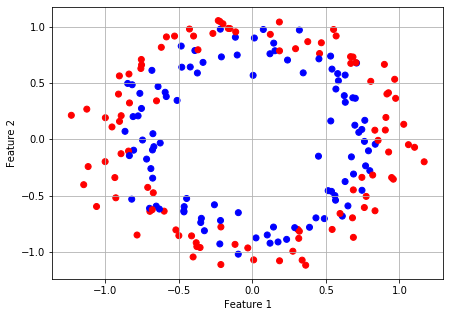

In [12]:
X, Y = generate_data('circles', 0.1)
Y = Y.reshape(1,len(Y))

color = ['blue' if y == 1 else 'red' for y in np.squeeze(Y)] # una lista para darle color a las clases

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], color=color)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()

plt.show()

<hr>

## 2.2. XOR y su descomposión lineal

El operador XOR puede utilizarse para ilustrar un problema de clasificación lineal que se puede descomponer en operaciones lineales o clasificaciones lineales.

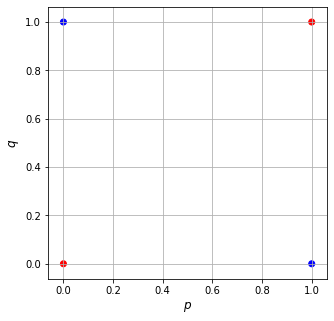

In [3]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0, 1, 1, 0]])

color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], color=color)
plt.grid()
plt.xlabel(r'$p$', fontsize=12)
plt.ylabel(r'$q$', fontsize=12)

plt.show()

X = X.T

<hr>

Revisemos el operador y trabajemos sobre sus tablas de verdad:

<br>

<center><font size=5>$p \oplus q = (p \wedge \neg q) \vee (\neg p \wedge q) $</font></center>

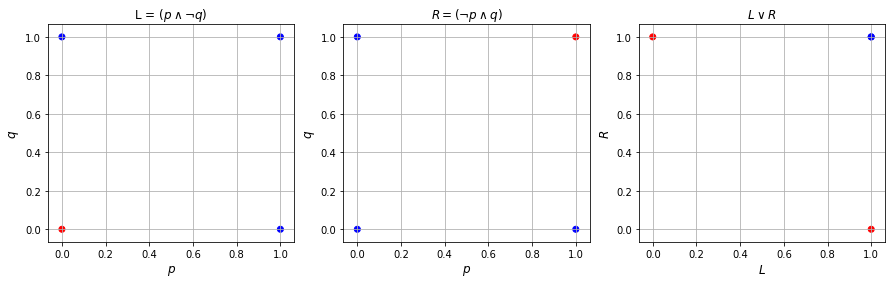

In [4]:
X1 = np.array([[0,0],[0,1],[1,0],[1,1]])
Y1 = np.array([[0, 1, 1, 1]])

X2 = np.array([[0,0],[0,1],[1,0],[1,1]])
Y2 = np.array([[1, 1, 1, 0]])

X3 = np.array([[0,1],[1,1],[1,1],[1,0]])
Y3 = np.array([[0, 1, 1, 0]])

color1 = ['blue' if y == 1 else 'red' for y in np.squeeze(Y1)]
color2 = ['blue' if y == 1 else 'red' for y in np.squeeze(Y2)]
color3 = ['blue' if y == 1 else 'red' for y in np.squeeze(Y3)]

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.title(r'L = $(p \wedge \neg q)$')
plt.scatter(X1[:,0], X1[:,1], color=color1)
plt.grid()
plt.xlabel(r'$p$', fontsize=12)
plt.ylabel(r'$q$', fontsize=12)

plt.subplot(132)
plt.title(r'$R = (\neg p \wedge q)$')
plt.scatter(X2[:,0], X2[:,1], color=color2)
plt.grid()
plt.xlabel(r'$p$', fontsize=12)
plt.ylabel(r'$q$', fontsize=12)

plt.subplot(133)
plt.title(r'$L \vee R$')
plt.scatter(X3[:,0], X3[:,1], color=color3)
plt.grid()
plt.xlabel(r'$L$', fontsize=12)
plt.ylabel(r'$R$', fontsize=12)

plt.show()

<hr>

El análisis anterior permite suponer que es posible entonces utilizar tres regresores logísticos para aprender cada una de las tres operaciones anteriores y concatenarlos de tal forma que permitan predecir el operador XOR a partir de las entradas.

Para ello, entrenaremos cada regresor por separado utilizando las tablas de verdad construidas en cada caso y finalmente los concatenaremos en una sola estructura como se puede observar en la siguiente figura:

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/layered_regresor.png?raw=true" width="500"/>

<br>

Analicemos el siguiente código:

In [7]:
#Utilicemos las mismas operaciones vectorizadas para los regresores logisticos.

def linear_activation(W, b, X):
    z = np.dot(W.T,X) + b
    
    return z

def sigmoid(z):
    a = 1. / (1. + np.exp(-z)) 
    
    return a 

def logloss(y, a):
    return -(y * np.log(a) + (1-y) * np.log(1-a))

def cost(L):
    return np.mean(L)

In [8]:
# Datasets, 1 por regresor

X1 = np.array([[0,0],[0,1],[1,0],[1,1]]).T
Y1 = np.array([[0, 1, 1, 1]])

X2 = np.array([[0,0],[0,1],[1,0],[1,1]]).T
Y2 = np.array([[1, 1, 1, 0]])

X3 = np.array([[0,1],[1,1],[1,1],[1,0]]).T
Y3 = np.array([[0, 1, 1, 0]])

In [9]:
# Parametros de los regresores 1, 2 y 3
np.random.seed(2)

m = len(X1)
nx = X1.shape[0]

W1 = np.random.random([nx, 1]) 
b1 = np.random.random()

W2 = np.random.random([nx, 1]) 
b2 = np.random.random()

W3 = np.random.random([nx, 1])
b3 = np.random.random()

# Parametros del descenso del gradiente
num_epochs = 2000
learning_rate = 0.1

for i in range(num_epochs):
    # Computacion de las activaciones de cada regresor
    Z1 = linear_activation(W1,b1,X1)
    A1 = sigmoid(Z1)
    
    Z2 = linear_activation(W2,b2,X2)
    A2 = sigmoid(Z2)
    
    Z3 = linear_activation(W3,b3,X3)
    A3 = sigmoid(Z3)
    
    # Calculo de gradientes
    dZ1 = A1 - Y1
    dW1 = np.dot(X1, dZ1.T) / m
    db1 = np.sum(dZ1) / m
    
    dZ2 = A2 - Y2
    dW2 = np.dot(X2, dZ2.T) / m
    db2 = np.sum(dZ2) / m
    
    dZ3 = A3 - Y3
    dW3 = np.dot(X3, dZ3.T) / m
    db3 = np.sum(dZ3) / m
    
    # Actualizacion de parametros
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    
    # Estimacion del costo
    J1 = cost(logloss(Y1,A1))
    J2 = cost(logloss(Y2,A2))
    J3 = cost(logloss(Y3,A3))

print("W1 actualizado: ",W1, "b1 actualizado: ", b1, " Costo final: ", J1)
print("W2 actualizado: ",W2, "b2 actualizado: ", b2, " Costo final: ", J2)
print("W3 actualizado: ",W3, "b3 actualizado: ", b3, " Costo final: ", J3)

W1 actualizado:  [[6.77488188]
 [6.77293279]] b1 actualizado:  -2.910445774033662  Costo final:  0.02366207325236112
W2 actualizado:  [[-5.56104732]
 [-5.56104798]] b2 actualizado:  8.52127477020537  Costo final:  0.043222492585462825
W3 actualizado:  [[6.1692902 ]
 [6.16929448]] b3 actualizado:  -9.067146868082938  Costo final:  0.04548529828891203


<hr>

Si bien ahora tenemos nuestros regresor entrenados de manera independiente, debemos conectarlos para poder predecir el valor de salida desde la entrada a los regresores 1 y 2, posteriormente concatenar ambas salidas como entradas para el regresor 3.

In [10]:
def predict_multilayer(W1,b1,W2,b2,W3,b3,X):
    Z1 = linear_activation(W1,b1,X)
    A1 = sigmoid(Z1)
    
    Z2 = linear_activation(W2,b2,X)
    A2 = sigmoid(Z2)
    
    X3 = np.concatenate((A1,A2), axis=0) #En este punto concatenamos A1 y A2 como entradas para el regresor 3
    Z3 = linear_activation(W3, b3, X3)
    A3 = sigmoid(Z3)
    
    return A3

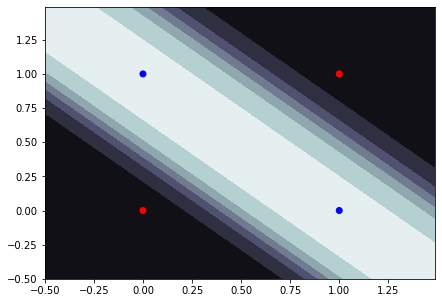

In [11]:
visualize_lr(W1, b1, W2, b2, W3, b3, X, Y) #Grafiquemos el mapa de separacion de nuestros regresores en cadena.

<hr>

<font size=4>
    
__Analicemos__: 

Si bien este ejercicio muestra que un conjunto de regresores en cadena puede aproximar problemas no-lineales, finalmente, esta aproximación de entrenamiento es inviable en cualquier caso. En qué radica dicha inviabilidad?

</font>